# Antimicrobial Peptide (AMP) recognition using the SGT

Sequence Graph Transform (SGT) is used for Sequence Embedding.
<br>
SGT reference: https://github.com/cran2367/sgt
<br>
SGT overview: https://towardsdatascience.com/sequence-embedding-for-clustering-and-classification-f816a66373fb

## All necessary imports

In [1]:
import sgt
from sgt import SGT

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

np.random.seed(7)  # for reproducibility
sgt.__version__

'2.0.3'

## Reading the AMP data

In [2]:
# Loading data
df = pd.read_csv('../data_instadeep/amp/all_data.csv')
print(df.shape)

(4042, 3)


There are 4042 samples.

In [3]:
df.head(5)

,PDBs_code,SequenceID,label
0,AP02484,GMASKAGSVLGKITKIALGAL,1
1,AP02630,NIGLFTSTCFSSQCFSSKCFTDTCFSSNCFTGRHQCGYTHGSC,1
2,AP01427,GAIKDALKGAAKTVAVELLKKAQCKLEKTC,1
3,AP02983,FFGRLKAVFRGARQGWKEHRY,1
4,AP01815,DFGCARGMIFVCMRRCARMYPGSTGYCQGFRCMCDTMIPIRRPPFIMG,1


In [4]:
df.sample(5)

,PDBs_code,SequenceID,label
3826,UniRef50_Q15257,NEVHEEKEQAA,0
318,AP02079,TPVVRKGRCSCISTNQGTIHLQSLKDLKQFAPSPSCEKIEIIATLK...,1
2698,UniRef50_Q6YR48,ALQNIIIAYEPVWAIGTGKSATPQDANKVIEQIRDKVTALYSSQAS...,0
1398,AP02351,QKIAEKFSGTRRG,1
2736,UniRef50_Q6FQ36,KHLNIIKSKGHVR,0


In [5]:
df.dtypes

PDBs_code     object
SequenceID    object
label          int64
dtype: object

In [6]:
print(f'{"Column":15s} # of unique values')
print(f'{"-"*40:60s}')
for col in df:
    print(f'{col:15s} {len(df[col].unique())}')

Column          # of unique values
----------------------------------------                    
PDBs_code       4042
SequenceID      4042
label           2


There are no duplicates.

In [7]:
# Any None entries?
df.isna().sum()

PDBs_code     0
SequenceID    0
label         0
dtype: int64

In [8]:
# Is the data balanced?
df['label'].value_counts(normalize=True)

1    0.5
0    0.5
Name: label, dtype: float64

The data is balanced.

## Protein Sequence Clustering

In [9]:
df.columns

Index(['PDBs_code', 'SequenceID', 'label'], dtype='object')

In [10]:
# Data preprocessing
df_pca = df.loc[:, ['PDBs_code', 'SequenceID']]
print(df_pca.head())

df_pca.columns = ['id', 'sequence']
df_pca['sequence'] = df_pca['sequence'].map(list)
df_pca

  PDBs_code                                        SequenceID
0   AP02484                             GMASKAGSVLGKITKIALGAL
1   AP02630       NIGLFTSTCFSSQCFSSKCFTDTCFSSNCFTGRHQCGYTHGSC
2   AP01427                    GAIKDALKGAAKTVAVELLKKAQCKLEKTC
3   AP02983                             FFGRLKAVFRGARQGWKEHRY
4   AP01815  DFGCARGMIFVCMRRCARMYPGSTGYCQGFRCMCDTMIPIRRPPFIMG


,id,sequence
0,AP02484,"[G, M, A, S, K, A, G, S, V, L, G, K, I, T, K, ..."
1,AP02630,"[N, I, G, L, F, T, S, T, C, F, S, S, Q, C, F, ..."
2,AP01427,"[G, A, I, K, D, A, L, K, G, A, A, K, T, V, A, ..."
3,AP02983,"[F, F, G, R, L, K, A, V, F, R, G, A, R, Q, G, ..."
4,AP01815,"[D, F, G, C, A, R, G, M, I, F, V, C, M, R, R, ..."
...,...,...
4037,UniRef50_C5DJ44,"[S, S, G, N, V, N, E, V, P, K, Q, N, A, K, H, ..."
4038,UniRef50_Q9XUP3,"[E, S, C, N, F, A, V, F, W, K, L, V, K, G, A, ..."
4039,UniRef50_Q9Y573,"[V, A, A, L, N, D, C, I, Y, S, V, G, G, W, N, ..."
4040,UniRef50_Q54H44,"[P, H, T, H, T, Q, K, E, V, I, T, S, S, V, D]"


In [11]:
%%time
# Compute SGT embeddings
sgt_ = SGT(kappa=1, lengthsensitive=False)
sgtembedding_df = sgt_.fit_transform(df_pca)

CPU times: user 25.4 s, sys: 302 ms, total: 25.7 s
Wall time: 26.5 s


In [12]:
sgtembedding_df

,id,"(A, A)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)",...,"(Y, N)","(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, V)","(Y, W)","(Y, X)","(Y, Y)"
0,AP02484,0.016599,0.000000,0.000000e+00,0.000000,0.000000,0.075515,0.000000,0.000251,0.027613,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.0,0.000000e+00
1,AP02630,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.018316,0.367879,0.000000,0.00000,0.0,0.000000e+00
2,AP01427,0.029188,0.011316,4.978707e-02,0.013226,0.000000,0.025349,0.000000,0.367879,0.028988,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.0,0.000000e+00
3,AP02983,0.006738,0.000000,0.000000e+00,0.001248,0.135335,0.022813,0.000459,0.000000,0.003392,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.0,0.000000e+00
4,AP01815,0.000006,0.000122,7.615037e-09,0.000000,0.001348,0.015824,0.000000,0.002617,0.000000,...,0.000000,5.255454e-02,0.067835,1.125845e-03,0.049787,0.006120,0.000000,0.00000,0.0,2.478752e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,UniRef50_C5DJ44,0.005801,0.000912,6.737947e-03,0.015050,0.000000,0.023076,0.034676,0.034065,0.052366,...,0.000000,0.000000e+00,0.000000,1.234098e-04,0.006738,0.000000,0.000000,0.00000,0.0,0.000000e+00
4038,UniRef50_Q9XUP3,0.006821,0.092590,1.933361e-02,0.001230,0.012014,0.001057,0.016596,0.001846,0.011325,...,0.003825,2.298996e-02,0.000011,1.244677e-02,0.000310,0.011406,0.001923,0.00000,0.0,4.658886e-15
4039,UniRef50_Q9Y573,0.024751,0.010698,1.702572e-02,0.000401,0.000041,0.040938,0.045112,0.004608,0.005227,...,0.000826,5.626759e-08,0.000123,2.069969e-08,0.147153,0.000168,0.009694,0.00255,0.0,1.522998e-08
4040,UniRef50_Q54H44,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.0,0.000000e+00


This is the embedding generated using the SGT.

In [13]:
# Set the id column as the dataframe index
sgtembedding_df = sgtembedding_df.set_index('id')
sgtembedding_df

,"(A, A)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)","(A, L)",...,"(Y, N)","(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, V)","(Y, W)","(Y, X)","(Y, Y)"
id,,,,,,,,,,,,,,,,,,,,,
AP02484,0.016599,0.000000,0.000000e+00,0.000000,0.000000,0.075515,0.000000,0.000251,0.027613,0.085923,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.0,0.000000e+00
AP02630,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.018316,0.367879,0.000000,0.00000,0.0,0.000000e+00
AP01427,0.029188,0.011316,4.978707e-02,0.013226,0.000000,0.025349,0.000000,0.367879,0.028988,0.025709,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.0,0.000000e+00
AP02983,0.006738,0.000000,0.000000e+00,0.001248,0.135335,0.022813,0.000459,0.000000,0.003392,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.0,0.000000e+00
AP01815,0.000006,0.000122,7.615037e-09,0.000000,0.001348,0.015824,0.000000,0.002617,0.000000,0.000000,...,0.000000,5.255454e-02,0.067835,1.125845e-03,0.049787,0.006120,0.000000,0.00000,0.0,2.478752e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UniRef50_C5DJ44,0.005801,0.000912,6.737947e-03,0.015050,0.000000,0.023076,0.034676,0.034065,0.052366,0.024902,...,0.000000,0.000000e+00,0.000000,1.234098e-04,0.006738,0.000000,0.000000,0.00000,0.0,0.000000e+00
UniRef50_Q9XUP3,0.006821,0.092590,1.933361e-02,0.001230,0.012014,0.001057,0.016596,0.001846,0.011325,0.019734,...,0.003825,2.298996e-02,0.000011,1.244677e-02,0.000310,0.011406,0.001923,0.00000,0.0,4.658886e-15
UniRef50_Q9Y573,0.024751,0.010698,1.702572e-02,0.000401,0.000041,0.040938,0.045112,0.004608,0.005227,0.174219,...,0.000826,5.626759e-08,0.000123,2.069969e-08,0.147153,0.000168,0.009694,0.00255,0.0,1.522998e-08


We perform PCA on the sequence embeddings and then do k-means clustering.

In [14]:
# Number of components vs explained variance %
nc_all = sgtembedding_df.shape[1] - 1  # = total nc (number of components)
x_nc = []  # nc = no of components
y_ev = []  # ev = explained variance %
for n in range(1, nc_all + 1):
    pca = PCA(n_components=n)
    pca.fit(sgtembedding_df)
    x_nc.append(n)
    y_ev.append(np.sum(pca.explained_variance_ratio_))

Text(0, 0.5, 'explained variance %')

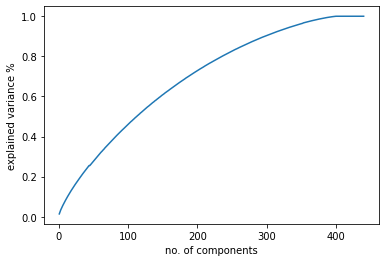

In [15]:
plt.plot(x_nc, y_ev)
plt.xlabel('no. of components')
plt.ylabel('explained variance %')

In [16]:
pca = PCA(n_components=2)
pca.fit(sgtembedding_df)
X=pca.transform(sgtembedding_df)
print(f'Explained variance with only the first 2 components: {np.sum(pca.explained_variance_ratio_): .3f}')

Explained variance with only the first 2 components:  0.024


In [17]:
df_kmeans = pd.DataFrame(data=X, columns=['x1', 'x2'])
df_kmeans.head(5)

,x1,x2
0,0.258864,0.051820
1,-0.017243,-0.078733
2,0.093602,0.220247
3,-0.026706,-0.038862
4,-0.036338,-0.134751


In [18]:
df_kmeans['label'] = df['label']
df_kmeans

,x1,x2,label
0,0.258864,0.051820,1
1,-0.017243,-0.078733,1
2,0.093602,0.220247,1
3,-0.026706,-0.038862,1
4,-0.036338,-0.134751,1
...,...,...,...
4037,-0.081113,-0.001069,0
4038,-0.098852,-0.054832,0
4039,-0.153414,0.025258,0
4040,-0.093898,0.059493,0


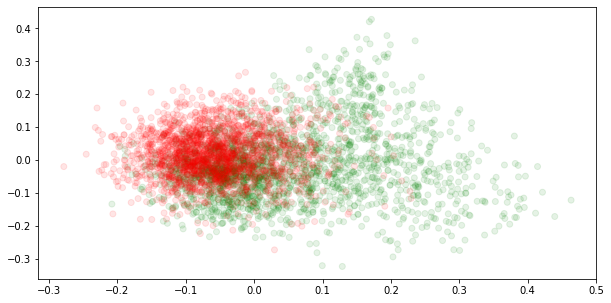

In [19]:
labels = df_kmeans['label']

fig = plt.figure(figsize=(10, 5))
colmap = {0: 'r', 1: 'g'}
colors = list(map(lambda x: colmap[x], labels))
plt.scatter(df_kmeans['x1'], df_kmeans['x2'], color=colors, alpha=0.1, edgecolor=colors)

In 2D, the negative examples (in red) seem to have a tigher cluster, compared to the positive examples (in green).

In [20]:
df_kmeans = pd.DataFrame(data=X, columns=['x1', 'x2'])
df_kmeans

,x1,x2
0,0.258864,0.051820
1,-0.017243,-0.078733
2,0.093602,0.220247
3,-0.026706,-0.038862
4,-0.036338,-0.134751
...,...,...
4037,-0.081113,-0.001069
4038,-0.098852,-0.054832
4039,-0.153414,0.025258
4040,-0.093898,0.059493


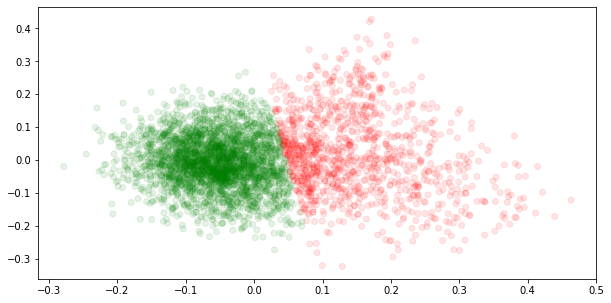

In [21]:
kmeans = KMeans(n_clusters=2, max_iter =300)
kmeans.fit(df_kmeans)

labels = kmeans.predict(df_kmeans)

fig = plt.figure(figsize=(10, 5))
colmap = {1: 'r', 2: 'g'}
colors = list(map(lambda x: colmap[x+1], labels))
plt.scatter(df_kmeans['x1'], df_kmeans['x2'], color=colors, alpha=0.1, edgecolor=colors)

Kmeans with 2 clusters does not separate the data well. This was expected as this was done with only the first 2 components from the PCA, which has a very low explained variance of 0.024.

## Sequence Classification using Deep Learning

In [2]:
# Loading data
data = pd.read_csv('../data_instadeep/amp/all_data.csv')
data.head()

,PDBs_code,SequenceID,label
0,AP02484,GMASKAGSVLGKITKIALGAL,1
1,AP02630,NIGLFTSTCFSSQCFSSKCFTDTCFSSNCFTGRHQCGYTHGSC,1
2,AP01427,GAIKDALKGAAKTVAVELLKKAQCKLEKTC,1
3,AP02983,FFGRLKAVFRGARQGWKEHRY,1
4,AP01815,DFGCARGMIFVCMRRCARMYPGSTGYCQGFRCMCDTMIPIRRPPFIMG,1


In [3]:
# shuffle the rows
# https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
data = data.sample(frac=1)
print(data.shape)
data.head(5)

(4042, 3)


,PDBs_code,SequenceID,label
3826,UniRef50_Q15257,NEVHEEKEQAA,0
318,AP02079,TPVVRKGRCSCISTNQGTIHLQSLKDLKQFAPSPSCEKIEIIATLK...,1
2698,UniRef50_Q6YR48,ALQNIIIAYEPVWAIGTGKSATPQDANKVIEQIRDKVTALYSSQAS...,0
1398,AP02351,QKIAEKFSGTRRG,1
2736,UniRef50_Q6FQ36,KHLNIIKSKGHVR,0


In [4]:


# Data preprocessing
y = np.array(data['label'])

corpus = data.loc[:,['PDBs_code', 'SequenceID']]
corpus.columns = ['id', 'sequence']
corpus['sequence'] = corpus['sequence'].map(list)
corpus

,id,sequence
3826,UniRef50_Q15257,"[N, E, V, H, E, E, K, E, Q, A, A]"
318,AP02079,"[T, P, V, V, R, K, G, R, C, S, C, I, S, T, N, ..."
2698,UniRef50_Q6YR48,"[A, L, Q, N, I, I, I, A, Y, E, P, V, W, A, I, ..."
1398,AP02351,"[Q, K, I, A, E, K, F, S, G, T, R, R, G]"
2736,UniRef50_Q6FQ36,"[K, H, L, N, I, I, K, S, K, G, H, V, R]"
...,...,...
1603,AP01917,"[G, L, W, D, S, I, K, N, F, G, K, T, I, A, L, ..."
2550,UniRef50_P27515,"[L, A, T, E, V, G, I, R, R, I, L, N, A, F, D, ..."
537,AP00206,"[W, K, S, E, S, L, C, T, P, G, C, V, T, G, A, ..."
1220,AP00357,"[F, F, P, I, G, V, F, C, K, I, F, K, T, C]"


In [5]:
# Sequence embedding
sgt_ = SGT(kappa=1, lengthsensitive=False)
sgtembedding_df = sgt_.fit_transform(corpus)
X = sgtembedding_df.set_index('id')
X

,"(A, A)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)","(A, L)",...,"(Y, N)","(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, V)","(Y, W)","(Y, X)","(Y, Y)"
id,,,,,,,,,,,,,,,,,,,,,
UniRef50_Q15257,0.367879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
AP02079,0.000002,0.002287,0.073576,0.002620,0.000000,0.001348,4.629316e-12,4.793862e-04,1.884270e-03,0.014212,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
UniRef50_Q6YR48,0.001411,0.019382,0.002051,0.008947,0.000000,0.007163,0.000000e+00,1.661923e-02,8.765262e-03,0.046140,...,0.000084,0.027067,0.007113,0.000041,0.043577,0.000059,0.007842,0.018316,0.0,0.000002
AP02351,0.000000,0.000000,0.000000,0.367879,0.049787,0.003431,0.000000e+00,0.000000e+00,1.353353e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
UniRef50_Q6FQ36,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AP01917,0.000000,0.000062,0.006738,0.000000,0.000000,0.000003,0.000000e+00,4.642918e-04,9.532049e-04,0.367879,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
UniRef50_P27515,0.000017,0.000000,0.067669,0.135335,0.092055,0.018316,0.000000e+00,1.996327e-03,9.157972e-03,0.000123,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
AP00206,0.000000,0.006112,0.000000,0.000000,0.006738,0.000000,0.000000e+00,3.059023e-07,4.364640e-07,0.123494,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


We will perform a 10-fold cross-validation to measure the performance of the classification model.

In [6]:
kfold = 10
random_state = 1

test_accuracy = np.zeros(kfold)
test_recall = np.zeros(kfold)
test_f1 = np.zeros(kfold)
skf = KFold(n_splits = kfold, shuffle = True, random_state = random_state)
k = 0
epochs = 50
batch_size = 128

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = Sequential()
    model.add(Dense(64, input_shape = (X_train.shape[1],), activation='relu')) 
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    
    y_pred = model.predict(X_test).round().astype(int)

    test_accuracy[k] = sklearn.metrics.accuracy_score(y_test, y_pred)
    test_recall[k] = sklearn.metrics.recall_score(y_test, y_pred)
    test_f1[k] = sklearn.metrics.f1_score(y_test, y_pred)
    k+=1
    
print ('Average accuracy score', np.mean(test_accuracy))
print ('Average recall score', np.mean(test_recall))
print ('Average f1 score', np.mean(test_f1))

2022-10-05 23:31:33.599815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


114/114 [==============================] - 0s 2ms/step
Average accuracy score 0.8253324776922139
Average recall score 0.824222718238359
Average f1 score 0.8249221240580387


For the given problem, accuracy seems like a good metric. With this simple SGT we achieved a 82.5% accuracy.